In [1]:
!jt -t grade3 -f roboto -fs 95 -altout -tfs 14 -nfs 115 -cellw 90% -T -cursc r -cursw 5 -dfs 8 -N
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: XLA_PYTHON_CLIENT_PREALLOCATE=false
env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [2]:
import sys
import os
import string
import jax

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

from stats import trials_until_correct, running_mean, performance

from jax import random, lax, nn
from jupyterthemes import jtplot
from agents import Agent
from opt_einsum import contract

cwd = os.getcwd()
sys.path.append(cwd[:-len('befit/examples/temp_rev_learn/tmp_present/')])

jtplot.style(theme='grade3', context='paper', fscale=1.6, grid=False)

%matplotlib inline

def einsum(equation, *args):
    return contract(equation, *args, backend='jax')

In [3]:
from scipy import io
# load experiment and generate observations
data = io.loadmat('main/states_and_rewards.mat')
Sirr = data['irregular']['S'][0, 0][:, 0] - 1
Oirr = data['irregular']['R'][0, 0]
Sreg = data['regular']['S'][0, 0][:, 0] - 1
Oreg = data['regular']['R'][0, 0]

runs = 50

outcomes1 = np.concatenate([(Oreg[:, None].repeat(runs, -2) + 1)//2, 
                            (Oirr[:, None].repeat(runs, -2) + 1)//2], -2)
outcomes2 = np.concatenate([Sreg[:, None].repeat(runs, -1) + 2, 
                             Sirr[:, None].repeat(runs, -1) + 2], -1)[..., None]

outcomes = jnp.concatenate([outcomes1, outcomes2], -1)

subs = jnp.array(range(2 * runs))
def process(t, responses):
    return outcomes[t, subs, responses]

In [4]:
# POMDP simulator
def simulator(process, agent, seed=0, **model_kw):
    def sim_fn(carry, t):
        rng_key, prior = carry
        
        rng_key, _rng_key = random.split(rng_key)
        choices = agent.action_selection(_rng_key, prior, **model_kw)
        
        outcomes = process(t, choices)
        
        posterior = agent.learning(outcomes, choices, prior)
                
        return (rng_key, posterior), {'choices': choices,
                                      'beliefs': prior}
    
    rng_key = random.PRNGKey(seed)
    _, sequence = lax.scan(sim_fn, (rng_key, agent.prior), jnp.arange(len(outcomes)))
    sequence['choices'].block_until_ready()
    
    cpus = jax.devices("cpu")
    
    return jax.device_put(sequence, cpus[0])

In [5]:
def plot_trajectories(sequence, nu_range, label):
    ws = 201
    fig, axes = plt.subplots(2, 2, figsize=(16, 9), sharex=True, sharey='row')
    trials = jnp.arange(101, 901)

    for nu in nu_range:
        states = outcomes[..., -1] - 2
        corr = (states == sequence[nu]['choices']).astype(jnp.float32)
        corr = jnp.where(sequence[nu]['choices'] == 2, jnp.nan, corr)
        tuc = trials_until_correct(jnp.nan_to_num(corr).T, states.T, τ=3)
        rolling_tuc = running_mean(tuc, ws=ws)
        rolling_perf = performance(corr, ws=ws)
        
        for i in range(2):
            axes[0, i].plot(trials, rolling_perf[i:(i+1)*50].mean(0), lw=3, label=label + r'{}'.format(nu), alpha=.8);
            axes[0, i].vlines(800, 3, 12, color='gray', linestyle='--', lw=2)
            axes[1, i].plot(trials, rolling_tuc[i:(i+1)*50].mean(0), lw=3, label=label + r'{}'.format(nu), alpha=.8);
            axes[1, i].vlines(800, 5, 7.5, color='gray', linestyle='--', lw=2)

    axes[0, 1].legend(loc=2, title='Model', fontsize=14);

    axes[0, 0].set_ylabel('Performance');
    axes[1, 0].set_ylabel('TUC');
    axes[0, 0].set_title('Regular condition')
    axes[0, 1].set_title('Irregular condition')
    axes[1, 0].set_xlabel('trial')
    axes[1, 1].set_xlabel('trial')
    
    for i in range(2):
        axes[i, 0].text(-.075, 1., string.ascii_uppercase[i], transform=axes[i, 0].transAxes, size=20, weight='bold')

    fig.tight_layout()
    sns.despine(fig)

    return fig


In [6]:
N = outcomes.shape[-2]
sequences1 = {}
for nu in [1, 2, 3, 10]:
    agent = Agent(N, nu_max=nu, U=jnp.array([0., 1., 0, 0]))
    sequences1[nu] = simulator(process, 
                               agent,
                               seed=10101, 
                               gamma=10)
    del agent

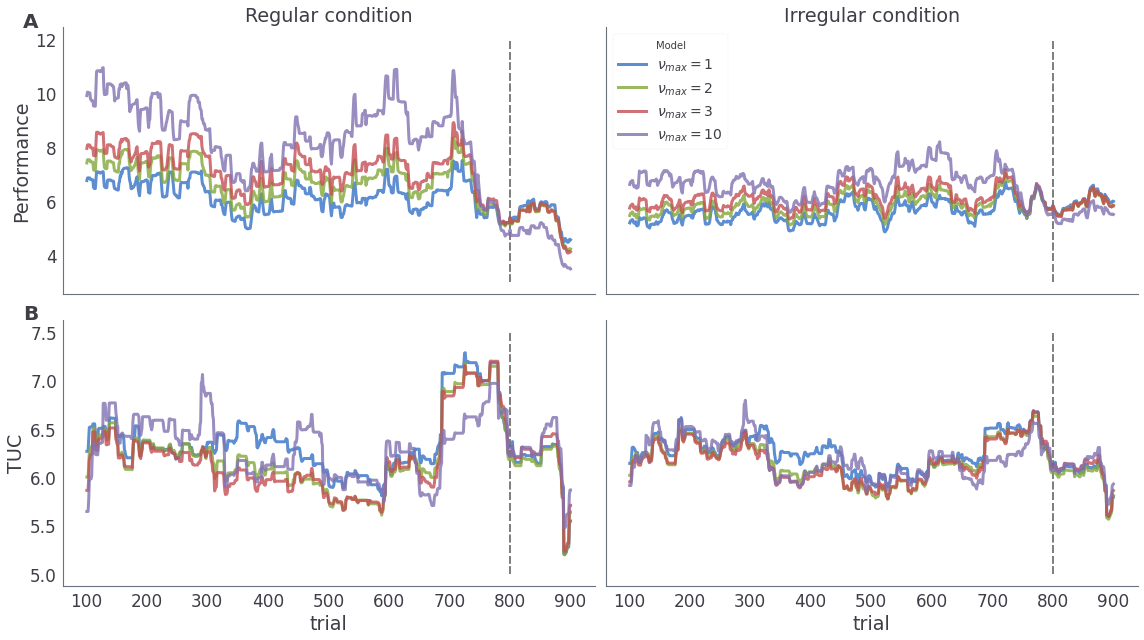

In [7]:
fig = plot_trajectories(sequences1, [1, 2, 3, 10], r'$\nu_{max}=$')
fig.savefig('Fig5.pdf', bbox_inches='tight', transparent=True, dpi=300)

In [8]:
N = outcomes.shape[-2]
sequences2 = {}
for nu in [0, 1, 5, 9]:
    agent = Agent(N, nu_max=10, nu_min=nu, U=jnp.array([0., 1., 0, 0]))
    sequences2[nu] = simulator(process, agent, seed=12365, gamma=10)
    del agent

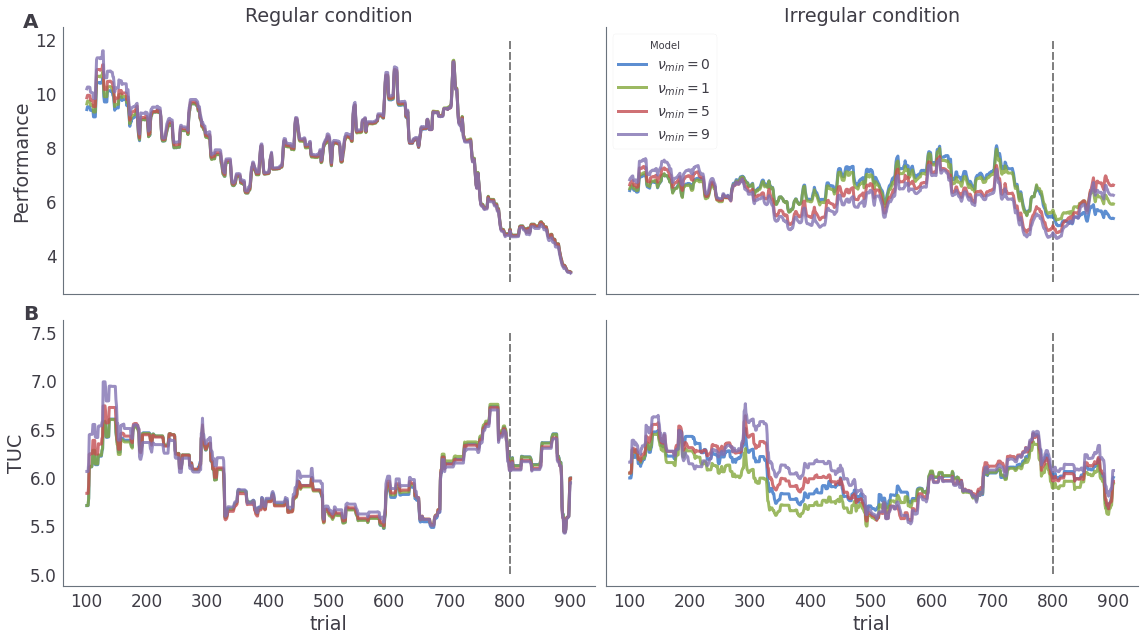

In [9]:
fig = plot_trajectories(sequences2, [0, 1, 5, 9], r'$\nu_{min}=$')
fig.savefig('supp_Fig5.pdf', bbox_inches='tight', transparent=True, dpi=300)

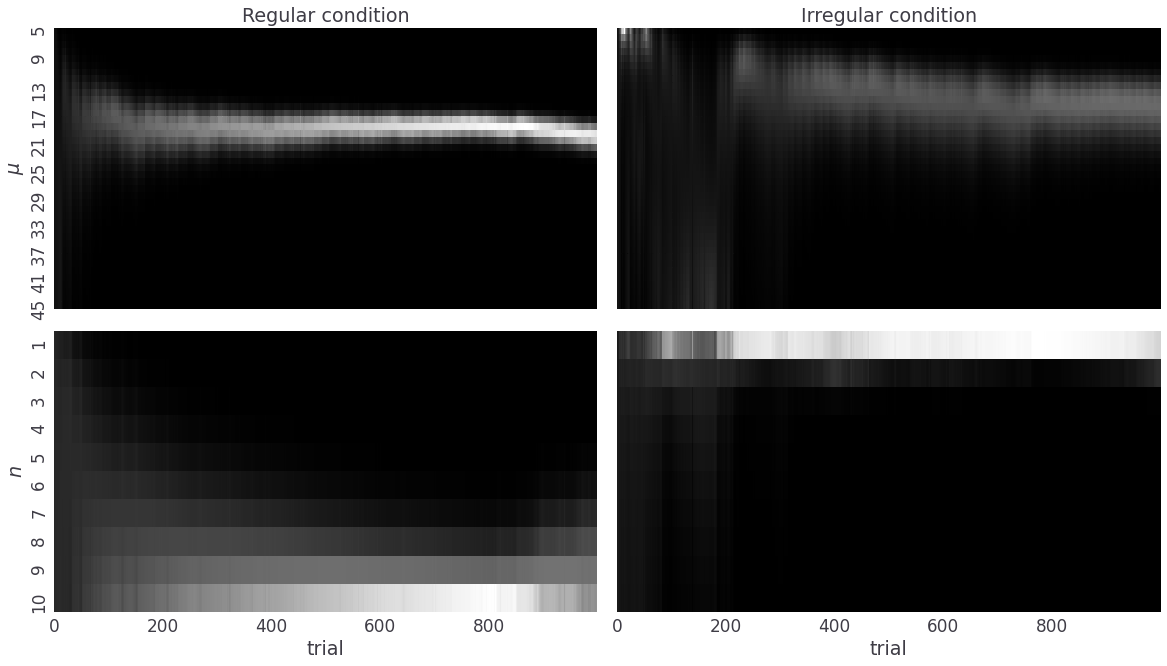

In [10]:
mu = jnp.arange(4, 45, 1)
nu = jnp.arange(1, 11, 1)
marg = einsum('...cfm->...m', sequences1[10]['beliefs'][0]).reshape(outcomes.shape[:-1] + (len(mu), len(nu)))

fig, axes = plt.subplots(2, 2, figsize=(16, 9), sharex=True, sharey='row')

for i, c in zip(range(2), [1, -1]):
    sns.heatmap(marg[:, c].sum(-1).T, ax=axes[0, i], cbar=False, cmap='gray')
    sns.heatmap(marg[:, c].sum(-2).T, ax=axes[1, i], cbar=False, cmap='gray')

fig.tight_layout()
axes[1, 0].set_xlabel('trial');
axes[1, 1].set_xlabel('trial');
axes[0, 0].set_ylabel(r'$\mu$');
axes[1, 0].set_ylabel(r'$n$');

axes[0, 0].set_yticklabels(mu.astype(int)[::4] + 1);
axes[1, 0].set_yticklabels(nu.astype(int));

trials = jnp.arange(0, marg.shape[0], 200);
axes[1, 0].set_xticks(trials);
axes[1, 0].set_xticklabels(trials, rotation=0);
axes[1, 1].set_xticklabels(trials, rotation=0);

axes[0, 0].set_title('Regular condition')
axes[0, 1].set_title('Irregular condition')

fig.savefig('Fig6.pdf', bbox_inches='tight', transparent=True, dpi=300)

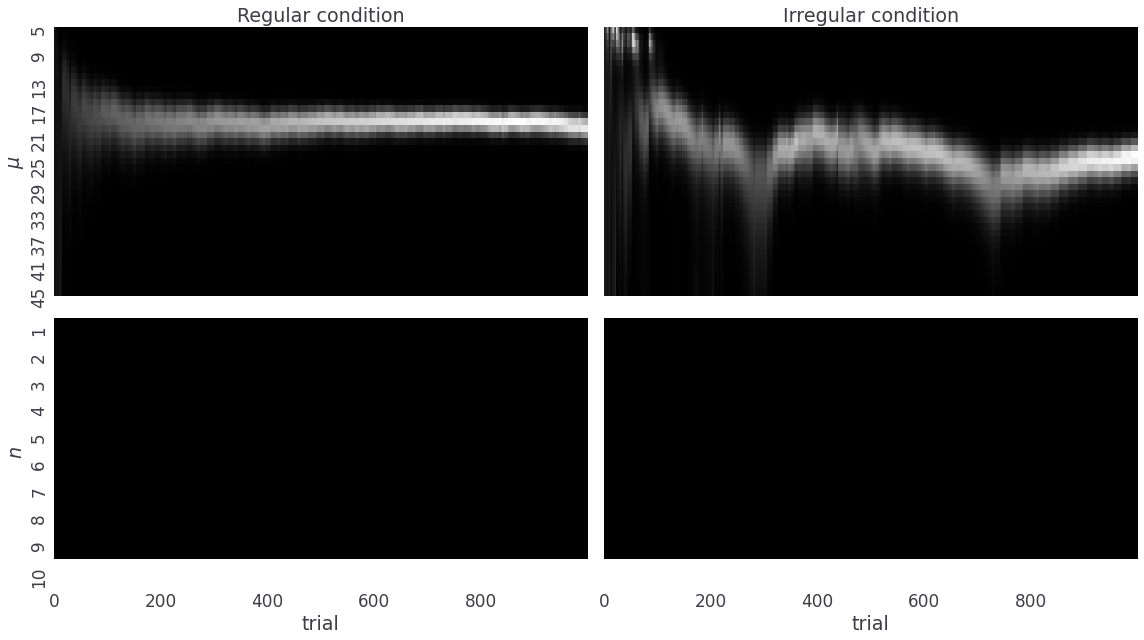

In [11]:
mu = jnp.arange(4, 45, 1)
nu = jnp.arange(1, 11, 1)
marg = einsum('...cfm->...m', sequences2[9]['beliefs'][0]).reshape(outcomes.shape[:-1] + (len(mu), len(nu)))

fig, axes = plt.subplots(2, 2, figsize=(16, 9), sharex=True, sharey='row')

for i, c in zip(range(2), [1, -1]):
    sns.heatmap(marg[:, c].sum(-1).T, ax=axes[0, i], cbar=False, cmap='gray')
    sns.heatmap(marg[:, c].sum(-2).T, ax=axes[1, i], cbar=False, cmap='gray')

axes[1, 0].set_xlabel('trial');
axes[1, 1].set_xlabel('trial');
axes[0, 0].set_ylabel(r'$\mu$');
axes[1, 0].set_ylabel(r'$n$');

axes[0, 0].set_yticklabels(mu.astype(int)[::4] + 1);
axes[1, 0].set_yticklabels(nu.astype(int));

trials = jnp.arange(0, marg.shape[0], 200);
axes[1, 0].set_xticks(trials);
axes[1, 0].set_xticklabels(trials, rotation=0);
axes[1, 1].set_xticklabels(trials, rotation=0);

axes[0, 0].set_title('Regular condition')
axes[0, 1].set_title('Irregular condition')

fig.tight_layout()
fig.savefig('supp_Fig6.pdf', bbox_inches='tight', transparent=True, dpi=300)

Text(8, -0.5, 'Irregular condition')

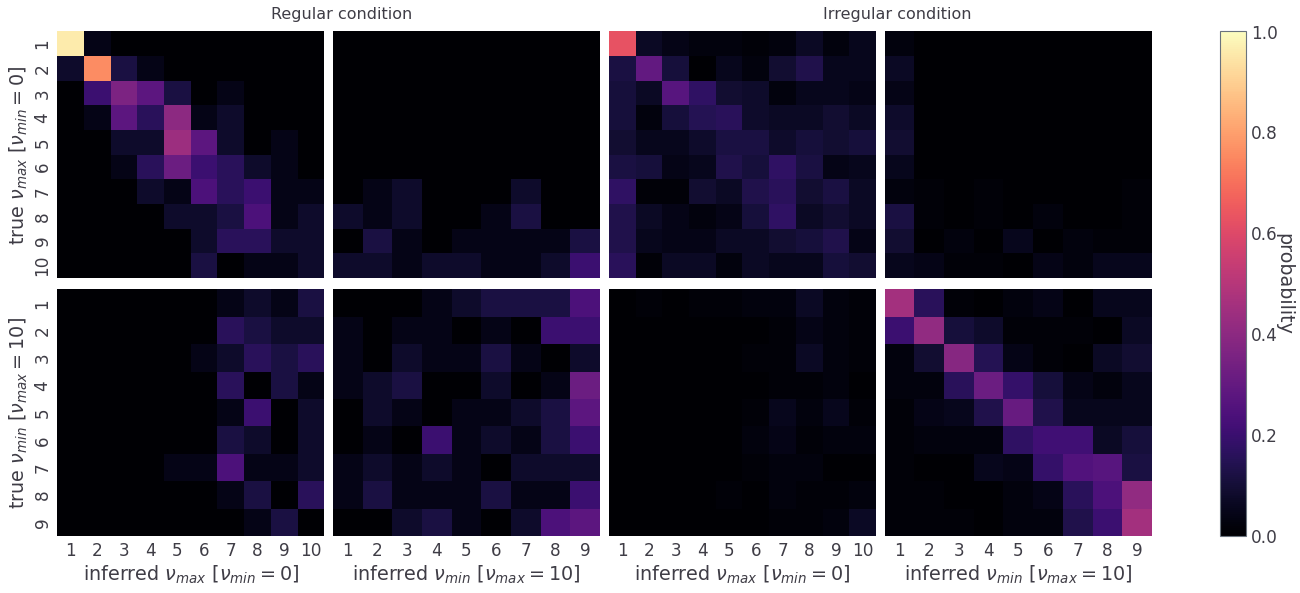

In [3]:
import numpy as np
from matplotlib import cm, colors

res_waic = np.load('fit_waic_sims/waic_sim_all_U-0-1-0-0_g4.npz', allow_pickle=True)['waic'].item()

d = len(res_waic)
n = len(res_waic[1][1])

waics = np.zeros((d, d, n))
for i, m_inf in enumerate(sorted(res_waic)):
    for j, m_true in enumerate(sorted(res_waic[m_inf])):
        waics[i, j] = res_waic[m_inf][m_true]

probs = nn.softmax(waics, 0)
maxes = np.eye(d)[:, np.argmax(probs, 0)]

exc_prob_c1 = maxes[..., :25].mean(-1)
exc_prob_c2 = maxes[..., 25:].mean(-1)

fig, axes = plt.subplots(2, 4, figsize=(20, 8), sharex='col', sharey='row')
ticks = [list(range(1, 11)), list(range(1, 10))]
labels1 = [r'true $\nu_{max}$ $\left[ \nu_{min}=0 \right]$', r'true $\nu_{min}$ $\left[ \nu_{max}=10 \right]$']
labels2 = [r'inferred $\nu_{max}$ $\left[ \nu_{min}=0 \right]$', r'inferred $\nu_{min}$ $\left[ \nu_{max}=10 \right]$']

for i in range(2):
    for j in range(2):
        sns.heatmap(exc_prob_c1.T[i*10:(i+1)*10, j*10:(j+1)*10], 
                    ax=axes[i, j], 
                    xticklabels=ticks[j], 
                    yticklabels=ticks[i], 
                    cbar=False, 
                    vmin=0, 
                    vmax=1, 
                    cmap='magma')
        sns.heatmap(exc_prob_c2.T[i*10:(i+1)*10, j*10:(j+1)*10], 
                    ax=axes[i, j+2], 
                    xticklabels=ticks[j], 
                    yticklabels=ticks[i], 
                    cbar=False, 
                    vmin=0, 
                    vmax=1, 
                    cmap='magma')
        if j == 0:
            axes[i, j].set_ylabel(labels1[i])
        if i == 1:
            axes[i, j].set_xlabel(labels2[j])
            axes[i, j+2].set_xlabel(labels2[j])
# 



fig.tight_layout()
norm = colors.Normalize(vmin=0, vmax=1)
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='magma'), ax=axes)
cbar.ax.set_ylabel('probability', rotation=-90, labelpad=15);
axes[0, 0].text(8, -.5, 'Regular condition', fontsize=16)
axes[0, 2].text(8, -.5, 'Irregular condition', fontsize=16)

# fig.savefig('sup_Fig12.pdf', bbox_inches='tight', dpi=300)

In [ ]:
res_waic = np.load('fit_waic_sims/waic_sim_all_U-1.5-2-0-0.npz', allow_pickle=True)['waic'].item()

d = len(res_waic)
n = len(res_waic[1][1])

waics = np.zeros((d, d, n))
for i, m_inf in enumerate(sorted(res_waic)):
    for j, m_true in enumerate(sorted(res_waic[m_inf])):
        waics[i, j] = res_waic[m_inf][m_true]

probs = nn.softmax(waics, 0)
maxes = np.eye(d)[:, np.argmax(probs, 0)]

exc_prob_c1 = maxes[..., :25].mean(-1)
exc_prob_c2 = maxes[..., 25:].mean(-1)

fig, axes = plt.subplots(2, 4, figsize=(20, 8), sharex='col', sharey='row')
ticks = [list(range(1, 11)), list(range(1, 10))]
labels1 = [r'true $\nu_{max}$ $\left[ \nu_{min}=0 \right]$', r'true $\nu_{min}$ $\left[ \nu_{max}=10 \right]$']
labels2 = [r'inferred $\nu_{max}$ $\left[ \nu_{min}=0 \right]$', r'inferred $\nu_{min}$ $\left[ \nu_{max}=10 \right]$']

for i in range(2):
    for j in range(2):
        sns.heatmap(exc_prob_c1.T[i*10:(i+1)*10, j*10:(j+1)*10], 
                    ax=axes[i, j], 
                    xticklabels=ticks[j], 
                    yticklabels=ticks[i], 
                    cbar=False, 
                    vmin=0, 
                    vmax=1, 
                    cmap='magma')
        sns.heatmap(exc_prob_c2.T[i*10:(i+1)*10, j*10:(j+1)*10], 
                    ax=axes[i, j+2], 
                    xticklabels=ticks[j], 
                    yticklabels=ticks[i], 
                    cbar=False, 
                    vmin=0, 
                    vmax=1, 
                    cmap='magma')
        if j == 0:
            axes[i, j].set_ylabel(labels1[i])
        if i == 1:
            axes[i, j].set_xlabel(labels2[j])
            axes[i, j+2].set_xlabel(labels2[j])
# 



fig.tight_layout()
norm = colors.Normalize(vmin=0, vmax=1)
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='magma'), ax=axes)
cbar.ax.set_ylabel('probability', rotation=-90, labelpad=15);
axes[0, 0].text(8, -.5, 'Regular condition', fontsize=16)
axes[0, 2].text(8, -.5, 'Irregular condition', fontsize=16)

Simulate behavioural measures for agents with varying $\lambda_+$ and $\lambda_-$.

In [81]:
cpus = jax.devices("cpu")
N = outcomes.shape[-2]
mus = jnp.arange(4., 45., 1.)
sequences_test = {}
for nu in [10]:
    dfs = []
    for lam_p in np.arange(.6, 2.2, .4):
        for lam_m in np.arange(-1., lam_p + .05, .1):
            agent = Agent(N, nu_max=nu, U=jnp.array([lam_m, lam_p, 0, 0]))
            sequence = simulator(process, agent, seed=347432, gamma=10)

            states = jax.device_put(outcomes[..., -1] - 2, cpus[0])
            corr = (states == sequence['choices']).astype(jnp.float16)
            expl = sequence['choices'] == 2
            corr = jnp.nanmean(jnp.where(expl, jnp.nan, corr)[200:800], axis=0)
            perf = corr/(1 - corr)
            expl = jnp.clip(expl[200:800].mean(0), 1e-10, 1-1e-10)
            odds = expl/(1 - expl)
            
            marg = einsum('...cfm->...m', sequence['beliefs'][0]).reshape(outcomes.shape[:-1] + (-1, nu))[-200]
            rmse_mu = jnp.sqrt(jnp.sum(marg.sum(-1) * (mus - 19)**2, -1))
            
            rmse_nu = jnp.sum(marg[:runs].sum(-2) * (jnp.arange(nu)+1 - 10)**2, -1)
            df = pd.DataFrame({'Performance': perf[:runs], 
                               'Exploration odds': odds[:runs], 
                              r'$RMSE_{\mu}$': rmse_mu[:runs], 
                              r'$RMSE_{\nu}$': rmse_nu})
            df[r'$\lambda_+$'] = float(f'{lam_p:.1f}')
            df[r'$\lambda_-$'] = lam_m
            df['condition'] = 'Regular'
            dfs.append(df)
            
            rmse_nu = jnp.sum(marg[runs:].sum(-2) * (jnp.arange(nu)+1 - 1)**2, -1)
            df = pd.DataFrame({'Performance': perf[runs:], 
                               'Exploration odds': odds[runs:], 
                               r'$RMSE_{\mu}$': rmse_mu[runs:], 
                               r'$RMSE_{\nu}$': rmse_nu})
            df[r'$\lambda_+$'] = float(f'{lam_p:.1f}')
            df[r'$\lambda_-$'] = lam_m
            df['condition'] = 'Irregular'
            dfs.append(df)
            
            del agent
    sequences_test[nu] = pd.concat(dfs, ignore_index=True)

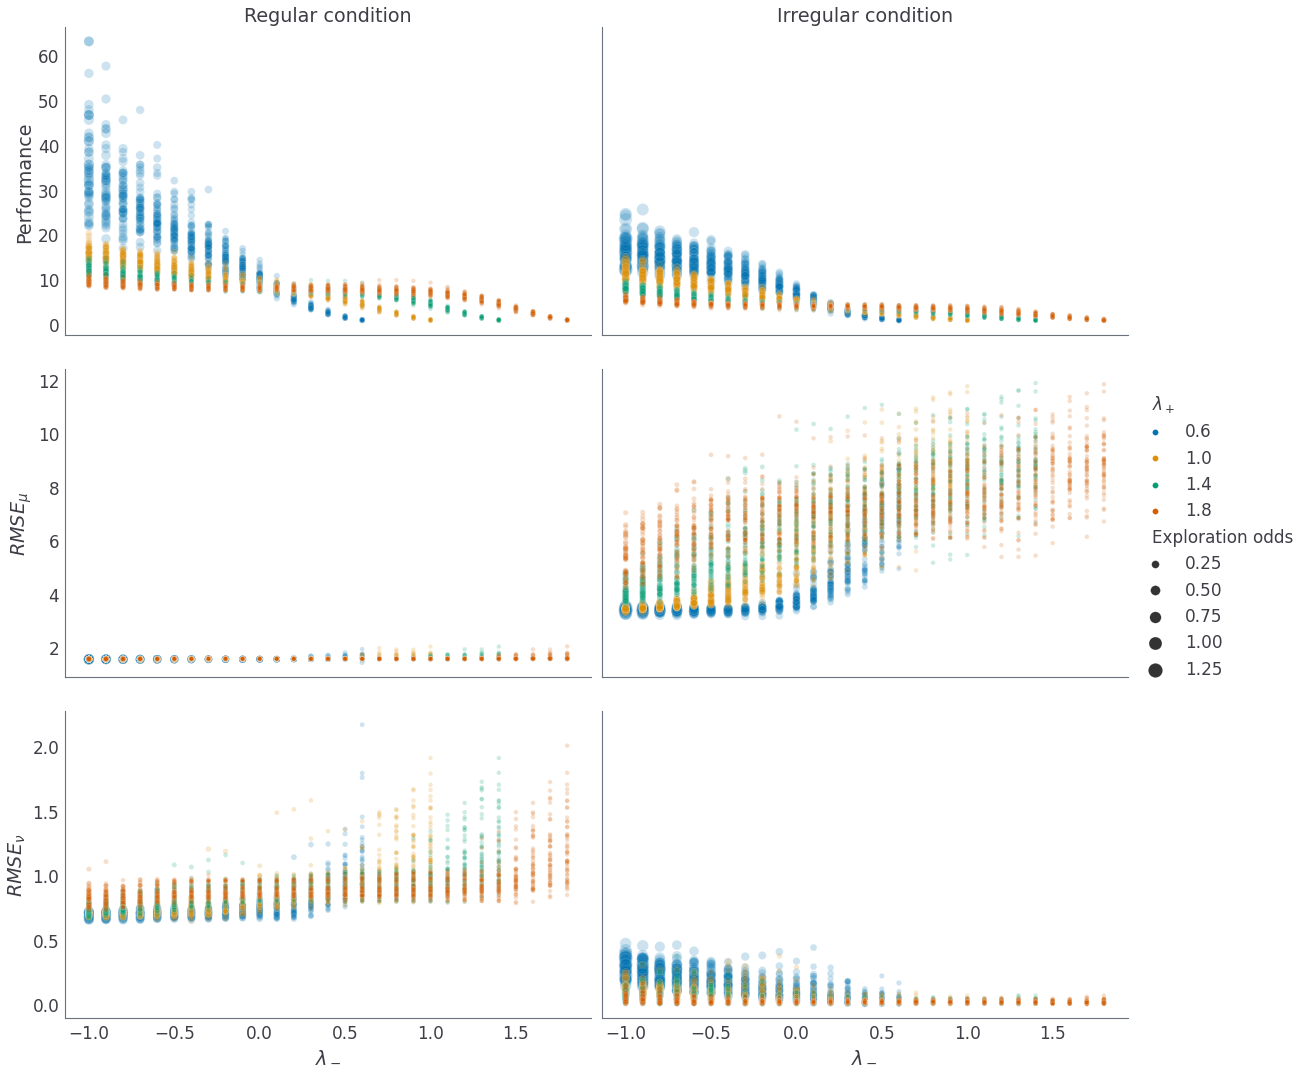

In [96]:
df1 = sequences_test[10].reset_index()
data1 = df1.loc[df1.condition == 'Irregular']
df2 = sequences_test[10].reset_index()
data2 = df2.loc[df2.condition == 'Regular']

data = pd.concat([data1, data2])
value_vars = ['Performance', r'$RMSE_{\mu}$', r'$RMSE_{\nu}$']
data_mlt= pd.melt(data, 
        id_vars=['condition', 'Exploration odds', r'$\lambda_+$', r'$\lambda_-$'], 
        value_vars=value_vars)

g = sns.relplot(data=data_mlt, x=r'$\lambda_-$', y='value', 
            hue=r'$\lambda_+$', size='Exploration odds', 
            col='condition', row='variable',
            sizes=(20, 200), alpha=.2, aspect=1.6, palette="colorblind", 
            col_order=['Regular', 'Irregular'], 
            row_order=value_vars, facet_kws={'sharey': 'row'},).set_titles("{col_name} condition")

for i, label in enumerate(value_vars):
    g.axes[i, 0].set_ylabel(label)
    if i > 0:
        for j in range(2):
            g.axes[i, j].set_title(None)

g.savefig('Fig7.pdf', bbox_inches='tight', dpi=300)